# LSTM Model Comparison With Data From Different Domains

In [ ]:
import sys
import os

# Add the project root (one level up from 'notebooks') to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
# Imports from our src/ modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import autocorrelation_plot

from src.data.load_fin_data import load_finance_data, load_fred_data
from src.data.preprocess_fin_data import enrich_target_stock, flatten_cols
from src.data.make_dataset import train_test_split
from src.data.split_sequences import prepare_train_val_test
from src.models.base_ARIMA import build_arima_model
from src.models.DL_LSTM import run_lstm_on_dataset, build_lstm_model, create_sequences, prepare_lstm_data, plot_predictions, evaluate_predictions, log_system_usage

from src.evaluation.evaluate import evaluate_model
from src.evaluation.metrics import generate_model_metrics
from src.data.scaler_utils import get_scaler
from src.data.adjusted_r2 import adjusted_r2

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler

from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

In [3]:
finance_data_no_lag = pd.read_csv('../data/dataset_finance/processed/processed_finance_data.csv')

finance_data_no_lag

,Date,Close_TSLA,Volume_TSLA,TSLA_Returns,TSLA_day,TSLA_month,TSLA_weekday,day_sin,day_cos,month_sin,...,Close_SOXX,Volume_SOXX,SOXX_Returns,PCE_Price_Index,Core_PCE_Price_Index,10-Year_Treasury_Yield,Federal_Funds_Rate,University_of_Michigan-Consumer_Sentiment,Consumer_Price_Index-All_Items-Total_for_United_States,Total_Vehicle_Sales
0,2014-09-17,17.425333,77665500.0,0.002454,17.0,9.0,2.0,-0.299363,-0.954139,-1.000000,...,26.093210,444000.0,0.007184,97.413,96.013,2.62,0.09,84.6,0.075257,16.959
1,2014-09-18,17.587999,55389000.0,0.009335,18.0,9.0,3.0,-0.485302,-0.874347,-1.000000,...,26.492056,355500.0,0.015285,97.413,96.013,2.63,0.09,84.6,0.075257,16.959
2,2014-09-19,17.288000,102163500.0,-0.017057,19.0,9.0,4.0,-0.651372,-0.758758,-1.000000,...,26.161163,339000.0,-0.012490,97.413,96.013,2.59,0.09,84.6,0.075257,16.959
3,2014-09-22,16.668667,123211500.0,-0.035824,22.0,9.0,0.0,-0.968077,-0.250653,-1.000000,...,25.845039,315600.0,-0.012084,97.413,96.013,2.57,0.09,84.6,0.075257,16.959
4,2014-09-23,16.694000,84880500.0,0.001520,23.0,9.0,1.0,-0.998717,-0.050649,-1.000000,...,25.762320,632700.0,-0.003201,97.413,96.013,2.54,0.09,84.6,0.075257,16.959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2373,2024-02-26,199.399994,111747100.0,0.038704,26.0,2.0,0.0,-0.848644,0.528964,0.866025,...,212.632172,3759000.0,0.009867,122.494,121.418,4.28,5.33,76.9,0.618967,16.177
2374,2024-02-27,199.729996,108645400.0,0.001655,27.0,2.0,1.0,-0.724793,0.688967,0.866025,...,212.420441,4560900.0,-0.000996,122.494,121.418,4.31,5.33,76.9,0.618967,16.177
2375,2024-02-28,202.039993,99806200.0,0.011566,28.0,2.0,2.0,-0.571268,0.820763,0.866025,...,210.031952,2923800.0,-0.011244,122.494,121.418,4.27,5.33,76.9,0.618967,16.177
2376,2024-02-29,201.880005,85907000.0,-0.000792,29.0,2.0,3.0,-0.394356,0.918958,0.866025,...,215.721985,3382800.0,0.027091,122.494,121.418,4.25,5.33,76.9,0.618967,16.177


[Before Training] Memory Usage: 489.59 MB | CPU Usage: 0.00%
Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0108 - val_loss: 0.0174
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.7141e-04 - val_loss: 0.0304
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.9318e-04 - val_loss: 0.0183
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.8665e-04 - val_loss: 0.0201
[After Training] Memory Usage: 549.61 MB | CPU Usage: 0.00%
Total Training Time: 8.54 seconds
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


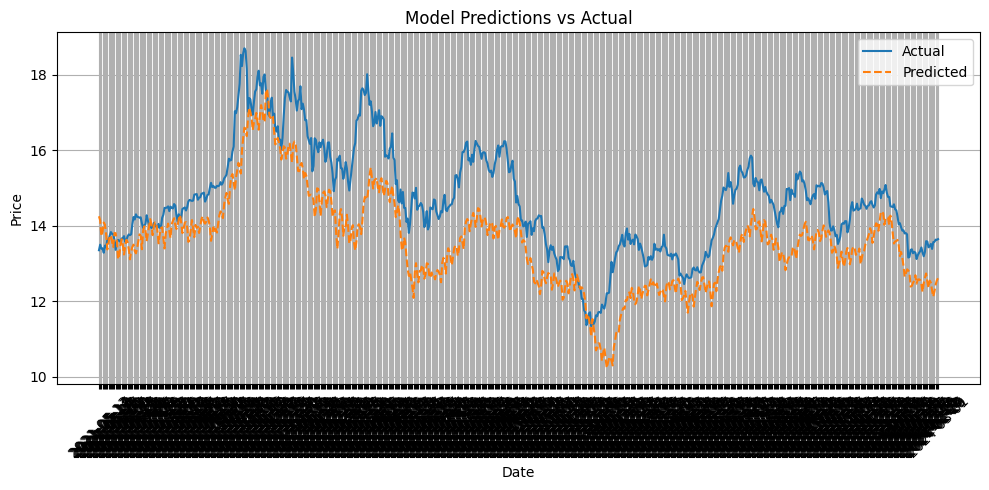

RMSE: 1.286, MSE: 1.653, MAE: 1.113, MAPE: 7.469, R²: 0.161, Adj_R²: 0.050


{'Dataset': 'Finance',
 'RMSE': 1.2857941642066775,
 'MSE': 1.6532666327079482,
 'MAE': 1.1131797266560834,
 'MAPE': 7.468779478356213,
 'R²': 0.16096720085268146,
 'Adj_R²': 0.050355159807536576}

In [ ]:
# Run LSTM Model on Finance Data

# Define parameters for LSTM model
data = finance_data_no_lag
finance_data_no_lag.name = "Finance"
target = 'Close_TSLA'  # Target variable to predict
date_col = 'Date'  # Column name for the date
seq_length = 30  # Number of time steps to look back
test_ratio = 0.3  # Proportion of data to use for testing
epochs = 10  # Number of epochs for training
batch_size = 32  # Batch size for training

finance_results = run_lstm_on_dataset(data, target, date_col, seq_length, test_ratio, epochs, batch_size)
finance_results

In [5]:
# load parquet data to pandas dataframe
retail_data_no_lag = pd.read_parquet('../data/dataset_retail/processed/data_no_lags_s1_i1.parquet')
retail_data_no_lag	= retail_data_no_lag.drop(columns=['split'])

retail_data_no_lag

,date,sales,year,month,day,dayofweek,dayofyear,weekofyear,quarter,is_month_start,is_month_end
0,2013-01-01,13,2013,1,1,1,1,1,1,1,0
1,2013-01-02,11,2013,1,2,2,2,1,1,0,0
2,2013-01-03,14,2013,1,3,3,3,1,1,0,0
3,2013-01-04,13,2013,1,4,4,4,1,1,0,0
4,2013-01-05,10,2013,1,5,5,5,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1821,2017-12-27,14,2017,12,27,2,361,52,4,0,0
1822,2017-12-28,19,2017,12,28,3,362,52,4,0,0
1823,2017-12-29,15,2017,12,29,4,363,52,4,0,0
1824,2017-12-30,27,2017,12,30,5,364,52,4,0,0


[Before Training] Memory Usage: 546.83 MB | CPU Usage: 0.00%
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0479 - val_loss: 0.0401
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0193 - val_loss: 0.0293
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0157 - val_loss: 0.0259
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0143 - val_loss: 0.0193
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0131 - val_loss: 0.0273
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0131 - val_loss: 0.0181
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0128 - val_loss: 0.0285
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0122 - val_loss: 0.0192
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0132 - val_loss: 0.0227
[After Training] Memory Usage: 581.36 MB | CPU Usage: 0.00%
Total Training Time: 11.45 seconds
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


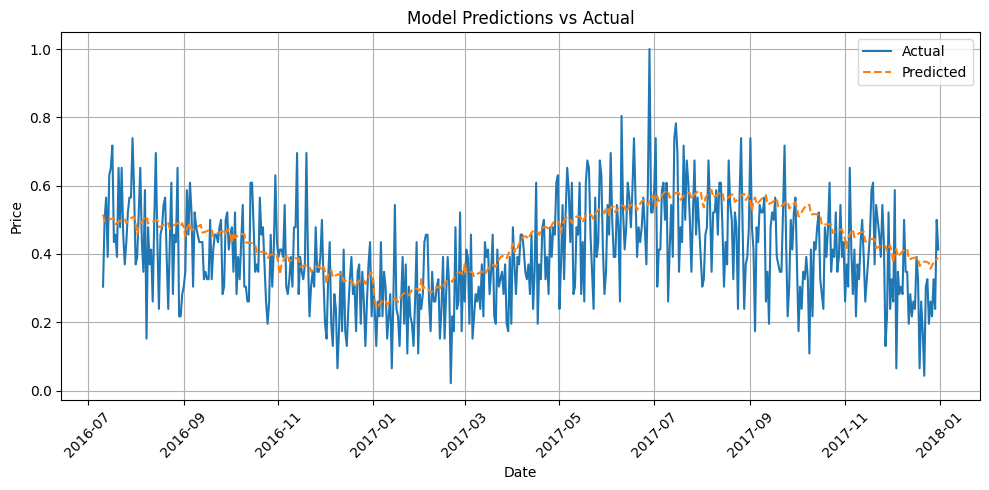

RMSE: 0.135, MSE: 0.018, MAE: 0.108, MAPE: 41.347, R²: 0.148, Adj_R²: 0.134


{'Dataset': 'Retail',
 'RMSE': 0.13468184081704798,
 'MSE': 0.01813919824586865,
 'MAE': 0.10763839387966757,
 'MAPE': 41.34710578603992,
 'R²': 0.14849434221913393,
 'Adj_R²': 0.13400747847617023}

In [6]:
# Run LSTM Model on Retail Data

# Define parameters for LSTM model
data = retail_data_no_lag
retail_data_no_lag.name = "Retail"
target = 'sales'  # Target variable to predict
date_col = 'date'  # Column name for the date
seq_length = 30  # Number of time steps to look back
test_ratio = 0.3  # Proportion of data to use for testing
epochs = 10  # Number of epochs for training
batch_size = 32  # Batch size for training

retail_results = run_lstm_on_dataset(data, target, date_col, seq_length, test_ratio, epochs, batch_size)
retail_results

In [10]:
transportation_data_no_lag = pd.read_csv('../data/dataset_transport/Baltimore.csv')
# transportation_data_no_lag['Month'] = transportation_data_no_lag['Month'].dt.strftime('%Y%m').astype(int)

transportation_data_no_lag

,Month,Container Tons,Auto Tons,Ro/Ro Tons (excl. autos),Forest Products (Break Bulk),Steel & other metals Break Bulk Tons,other Break Bulk Tons,Total General Cargo Tons,Import Loaded TEUs,Export Loaded TEUs,...,Import Empty TEUs,Export Empty TEUs,Total Empty TEUs,Total TEUs,Total Containers,Import Auto Units,Export Auto Units,Total Auto UNITS,Import Ro/Ro Tons,Export Ro/Ro Tons
0,Jan-98,360095,18386,32967,54189,15705,27515,508857,16051,17418,...,3199,1436,4635,38104,23789,9452,2391,11843,22160,10807
1,Feb-98,359722,20085,37156,42726,13805,31879,505373,16228,16846,...,3045,2056,5101,38175,23874,11206,1393,12599,23405,13751
2,Mar-98,377748,27610,57077,43910,10344,31001,547690,18577,18570,...,5906,3525,9431,46578,28926,14570,2967,17537,40470,16607
3,Apr-98,377397,21900,56087,48180,5663,33094,542321,17777,18157,...,2712,3070,5769,41703,25985,11715,2342,14057,39312,16775
4,May-98,382760,25824,40905,25530,4022,37509,516550,18178,17104,...,2407,3242,5626,40908,26250,15081,1790,16871,28865,12040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,Sep-24,600022,86008,66156,62312,1258,13768,829524,42751,13643,...,211,27538,27749,84143,49289,34044,6967,41011,46829,19327
321,Oct-24,526700,72803,56889,23489,417,7200,687498,37221,12053,...,94,22839,22933,72207,42427,21364,9838,31202,45205,11684
322,Nov-24,719903,112552,84434,71229,902,17902,1006922,44375,21030,...,83,20478,20561,85966,50420,37713,7524,45237,65513,18921
323,Dec-24,727972,107839,66784,48758,537,15307,967197,48036,18287,...,16,29195,29211,95534,55644,27943,9761,37704,51287,15497


[Before Training] Memory Usage: 640.07 MB | CPU Usage: 0.00%
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.1527 - val_loss: 0.0641
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0151 - val_loss: 0.0188
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0080 - val_loss: 0.0757
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0085 - val_loss: 0.0687
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0050 - val_loss: 0.0346
[After Training] Memory Usage: 623.76 MB | CPU Usage: 0.00%
Total Training Time: 6.31 seconds
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/stepWARNING:tensorflow:6 out of the last 23 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002298CF25C60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead

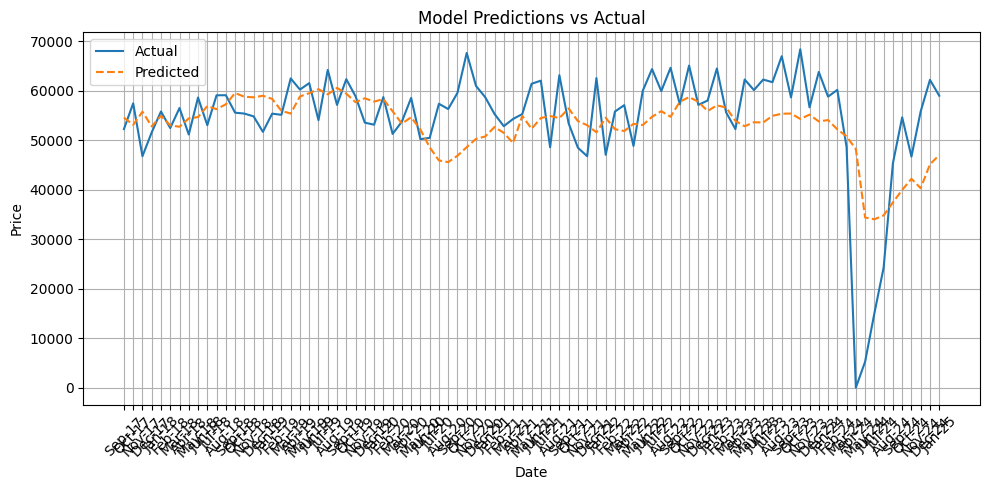

RMSE: 9377.766, MSE: 87942495.914, MAE: 6599.102, MAPE: inf, R²: 0.266, Adj_R²: 0.064


c:\Users\gnniv\Documents\NUS Msc In Data Science in Sustainability\DSS5104 Machine Learning and Predictive Modelling\CA2\ProjectFiles\GitHub\DSS5104-ForecastDL\src\models\DL_LSTM.py:77: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


{'Dataset': 'Transportation',
 'RMSE': 9377.766040715387,
 'MSE': 87942495.91439474,
 'MAE': 6599.102484495887,
 'MAPE': inf,
 'R²': 0.26613061472377586,
 'Adj_R²': 0.0640506390680039}

In [11]:
# Run LSTM Model on Transportation Data
data = transportation_data_no_lag
transportation_data_no_lag.name = "Transportation"
target = 'Total TEUs'
date_col = 'Month'  # Column name for the date
seq_length = 30  # Number of time steps to look back
test_ratio = 0.3  # Proportion of data to use for testing
epochs = 10  # Number of epochs for training
batch_size = 32  # Batch size for training

run_lstm_on_dataset(data, target, date_col, seq_length, test_ratio, epochs, batch_size)

In [15]:
climate_data_no_lag = pd.read_csv('../data/dataset_climate/raw/Temperature Data of California.csv')

climate_data_no_lag

,County,TIME,Mean_Temperature
0,Alameda,1981-01,9.869529
1,Alameda,1981-02,11.723992
2,Alameda,1981-03,11.615960
3,Alameda,1981-04,14.036708
4,Alameda,1981-05,16.333115
...,...,...,...
30445,Yuba,2024-05,18.278763
30446,Yuba,2024-06,23.837745
30447,Yuba,2024-07,28.044864
30448,Yuba,2024-08,24.305265


In [ ]:
# Run LSTM Model on Climate Data

# Define parameters for LSTM model
data = climate_data_no_lag
climate_data_no_lag.name = "Climate"
target = 'Mean_Temperature'
date_col = 'TIME'  # Column name for the date
seq_length = 30  # Number of time steps to look back
test_ratio = 0.3  # Proportion of data to use for testing
epochs = 10  # Number of epochs for training
batch_size = 32  # Batch size for training

climate_results = run_lstm_on_dataset(data, target, date_col, seq_length, test_ratio, epochs, batch_size)
climate_results

In [ ]:
energy_data_no_lag = pd.read_csv('../data/dataset_energy/df_no_lag_indicators.csv')

energy_data_no_lag

In [ ]:
# Run LSTM Model on Energy Data

# Define parameters for LSTM model
data = energy_data_no_lag
energy_data_no_lag.name = "Energy"
target = 'Energy_Demand'  # Target variable to predict
date_col = 'date'  # Column name for the date
seq_length = 30  # Number of time steps to look back
test_ratio = 0.3  # Proportion of data to use for testing
epochs = 10  # Number of epochs for training
batch_size = 32  # Batch size for training

energy_results = run_lstm_on_dataset(data, target, date_col, seq_length, test_ratio, epochs, batch_size)
energy_results

In [ ]:
# metrics_scores = {}
# metrics_scores[target_ticker] = {"RMSE": rmse, "MSE": mse, "MAE": mae, "MAPE": mape, "R2": r2, "Adj_R2": adj_r2}
# metrics_df = pd.DataFrame(metrics_scores).T  # Transpose so models are rows
# # metrics_df.to_csv("model_metrics_scores.csv")
# print(metrics_df)